# Determining Syntactic Features of English Registers

*Aeyzechiah Vasquez and Reese Porter*


This project's code is divided into 4 parts.
1. **Data collection** - collecting data tagged with their genre
2. **Data tagging** - tagging data with metrics. The 6 metrics under investigation are:
  1. Adverb frequency
  2. Personal pronoun frequency
  3. Perfect aspect frequency
  4. Progressive aspect frequency
  5. Modal/Semi-modal frequency
  6. Dependency distance
  7. F Score
    - *F-score was not included in evaluation*
3. **Modeling and Evaluation** - training models on each combination of features and evaluating their accuracy by F1 score
4. **Model visualization** - creating visualizations of the models and their predictions

In [1]:
!pip install convokit
!pip install seaborn

## 1. Data collection


In [2]:
from data_collection import academic, news, conversational

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\aeyzee\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\aeyzee\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aeyzee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset already exists at C:\Users\aeyzee\.convokit\downloads\movie-corpus


### Gather 10,000 datapoints for each genre

In [3]:
N = 10_000
academic_data = academic.get_academic_articles(N)
news_data = news.get_news_articles(N)
conversational_data = conversational.get_conversation_utterances(N)

99/10000 articles downloaded
199/10000 articles downloaded
299/10000 articles downloaded
399/10000 articles downloaded
499/10000 articles downloaded
598/10000 articles downloaded
599/10000 articles downloaded
697/10000 articles downloaded
797/10000 articles downloaded
897/10000 articles downloaded
997/10000 articles downloaded
1097/10000 articles downloaded
1197/10000 articles downloaded
1297/10000 articles downloaded
1397/10000 articles downloaded
1495/10000 articles downloaded
1595/10000 articles downloaded
1655/10000 articles downloaded
1755/10000 articles downloaded
1854/10000 articles downloaded
1954/10000 articles downloaded
1973/10000 articles downloaded
2073/10000 articles downloaded
2073/10000 articles downloaded
2170/10000 articles downloaded
2175/10000 articles downloaded
2274/10000 articles downloaded
2374/10000 articles downloaded
2473/10000 articles downloaded
2573/10000 articles downloaded
2672/10000 articles downloaded
2772/10000 articles downloaded
2872/10000 articles 

### Print some documents

In [4]:
# Print some documents
print('ACADEMIC:', academic_data[0])
print('NEWS:', news_data[0])
print('CONVERSATIONAL:', conversational_data[0])

ACADEMIC:  Estimating the mortality of birds and bats at wind turbines based on periodic carcass counts is challenging because carcasses may be removed by scavengers or may be missed in investigators' searches, leading to undercounting. Existing mortality estimators intended to correct for this offer wildly different estimates when search intervals are short. We introduce a new estimator that includes many existing ones as special cases but extends and improves them in three ways to reflect phenomena discovered in the field: * Decreasing removal rate by scavengers as carcasses age; * Diminishing proficiency of Field Technicians in discovering carcasses as they age; * Possibility that some (but not all) carcasses arriving in earlier search periods may be discovered in the current period. It is this feature that makes the new estimator "partially periodic". Both point estimates and 50% and 90% Objective Bayes interval estimates are provided for mortality. The new ACME mortality estimator

## 2. Data tagging

In [5]:
import spacy
from tagging.tagger import tag
from dataframe import create_dataframe
import pandas as pd

### Tag the data

In [6]:
# Tag each datapoint
academic_docs = map(tag, academic_data)
news_docs = map(tag, news_data)
conversational_docs = map(tag, conversational_data)

### Create dataframes

In [7]:
# Convert to pandas dataframe
academic_df = create_dataframe(genre='ACADEMIC', docs=academic_docs)
news_df = create_dataframe(genre='NEWS', docs=news_docs)
conversational_df = create_dataframe(genre='CONVERSATIONAL', docs=conversational_docs)

### Aggregate data into one dataframe

In [8]:
# Combine into 1 dataframe
df = pd.concat([academic_df, news_df, conversational_df])
df_grouped = df.groupby('genre').mean()

## 3. Modeling and Evaluation

### Graphs and Insight

These cells graph each feature metric with respect to their genres. These are useful for general validation of our hypotheses of which features should be most useful in classifying between genres.


[]

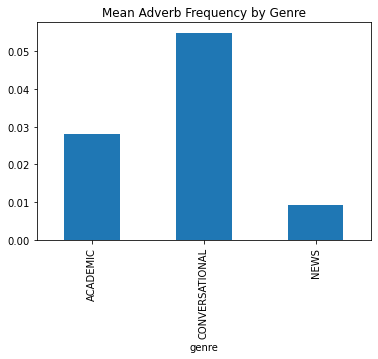

In [9]:
# Adverb Frequency
df_grouped.adverb_frequency.plot.bar(x='genre', y='adverb_frequency', title='Mean Adverb Frequency by Genre').plot()

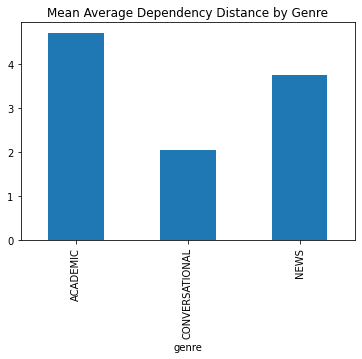

In [10]:
# Dependency Distance
df_grouped.average_dependency_distance.plot.bar(x='genre', y='average_dependency_distance', title='Mean Average Dependency Distance by Genre')

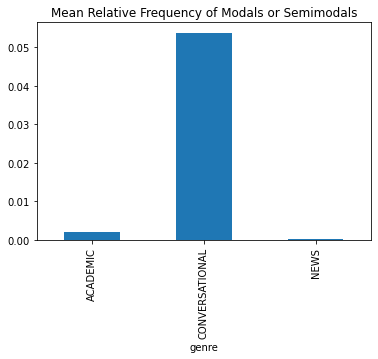

In [11]:
# Modal / Semimodal frequency
df_grouped.modal_semimodal_frequency.plot.bar(x='genre', y='modal_semimodal_frequency', title='Mean Relative Frequency of Modals or Semimodals')

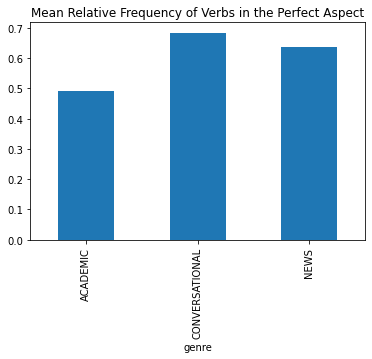

In [12]:
# Perfect Aspect
df_grouped.perfect_aspect_frequency.plot.bar(x='genre', y='perfect_aspect_frequency', title='Mean Relative Frequency of Verbs in the Perfect Aspect')

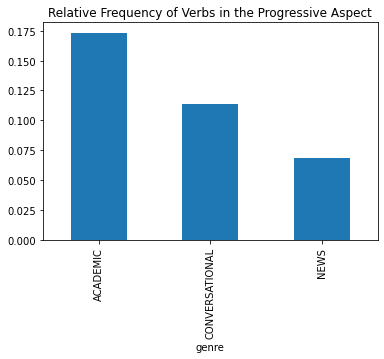

In [13]:
# Progressive Aspect Frequency
df_grouped.progressive_aspect_frequency.plot.bar(x='genre', y='progressive_aspect_frequency', title='Relative Frequency of Verbs in the Progressive Aspect')

[]

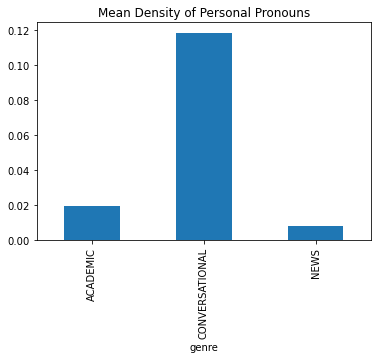

In [14]:
# Frequency of Personal Pronouns
df_grouped.personal_pronoun_frequency.plot.bar(x='genre', y='personal_pronoun_frequency', title='Mean Density of Personal Pronouns').plot()

[]

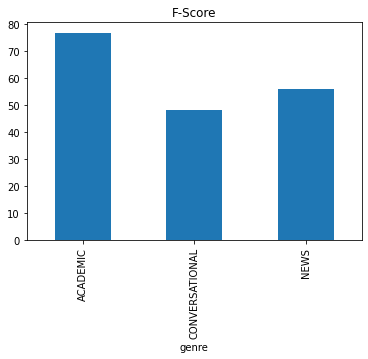

In [15]:
# Fscore
df_grouped.f_score.plot.bar(x='genre', y='fscore', title='F-Score').plot()

### Modeling all combinations

In [16]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

### Code for training and evaluating the classifier

In [17]:
# A function that takes a list of feature names and returns a model trained on those features
def train_svc_model(feature_names):
  # Instantiate a model
  model = LinearSVC(max_iter = 1_000_000)

  # Test train split (with constant seed)
  X_train, X_test, y_train, y_test, indices_test, indices_train = train_test_split(df[feature_names], df['genre'], df.index, test_size=0.5, random_state=0)

  # Reshape if required
  if len(feature_names) == 1:
    X_train = X_train.to_numpy().reshape(-1,1)
    X_test = X_test.to_numpy().reshape(-1,1)
    y_train = y_train.to_numpy().reshape(-1,1)
    y_test = y_test.to_numpy().reshape(-1, 1)

  # Train the model
  model.fit(X_train, y_train)

  # Predict test data genres
  y_pred = model.predict(X_test)

  # Evaluate and add evaluation metrics as attributes
  model.recall = recall_score(y_test, y_pred, average='macro')
  model.precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
  model.f1 = f1_score(y_test, y_pred, average='macro')

  # Add the feature names as an attribute
  model.features = feature_names

  # Add a method for printing the confusion matrix
  model.confusion_matrix = confusion_matrix(y_test, y_pred)

  def plot_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots()
    sns.heatmap(confusion_matrix, annot=True, fmt='d',
                xticklabels=set(df.genre.values), yticklabels=set(df.genre.values),
                square=True, linewidths=0.5)
    plt.ylabel('True Register')
    plt.xlabel('Predicted Register')
    plt.title('Confusion matrix')
    plt.show()
  model.plot_confusion_matrix = plot_confusion_matrix

  return model


### Train and evaluate a model for each combination of features

In [18]:

feature_names = [
  'average_dependency_distance',
  'adverb_frequency',
  'modal_semimodal_frequency',
  'perfect_aspect_frequency',
  'progressive_aspect_frequency',
  'personal_pronoun_frequency',
  #'f_score', # fscore removed to reduce number of models to just 64
]

# Get all combinations of features
combinations = []
for mask in range(1, 2**len(feature_names)):
  combination = [feature for feature in feature_names if 2**feature_names.index(feature) & mask != 0]
  combinations.append(combination)

# Train models on each combination of features
models = list(map(train_svc_model, combinations))

c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

## 4. Model visualization

0.8226746882974109 ['average_dependency_distance', 'adverb_frequency', 'modal_semimodal_frequency', 'perfect_aspect_frequency', 'progressive_aspect_frequency', 'personal_pronoun_frequency']


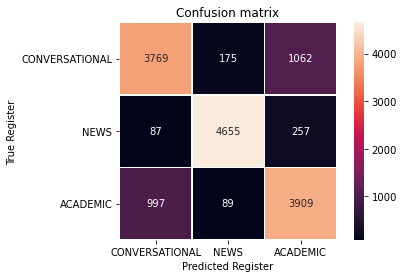

0.8218253200020533 ['average_dependency_distance', 'adverb_frequency', 'perfect_aspect_frequency', 'progressive_aspect_frequency', 'personal_pronoun_frequency']


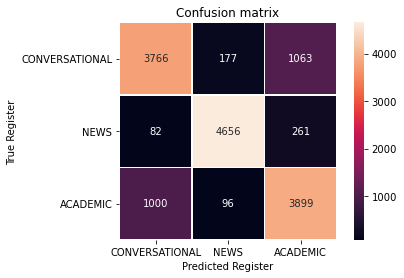

0.8138224300039241 ['average_dependency_distance', 'adverb_frequency', 'modal_semimodal_frequency', 'perfect_aspect_frequency', 'personal_pronoun_frequency']


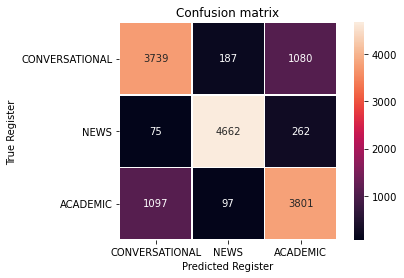

0.8125309278027002 ['average_dependency_distance', 'adverb_frequency', 'perfect_aspect_frequency', 'personal_pronoun_frequency']


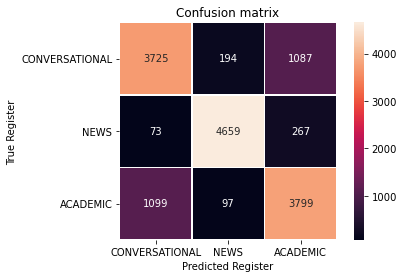

0.37393954026905596 ['perfect_aspect_frequency']


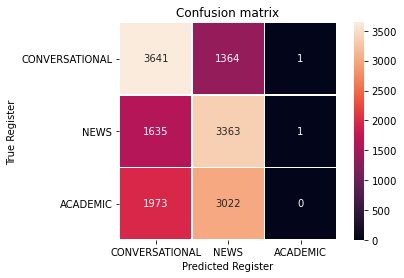

0.37267238914995876 ['progressive_aspect_frequency']


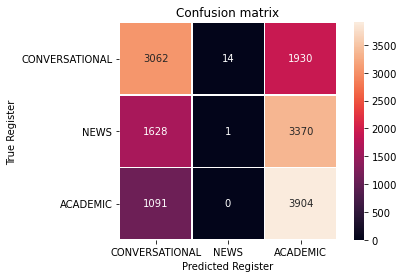

0.3127894932312593 ['modal_semimodal_frequency']


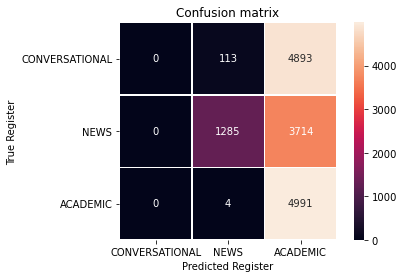

0.4400705937620879 ['perfect_aspect_frequency', 'progressive_aspect_frequency']


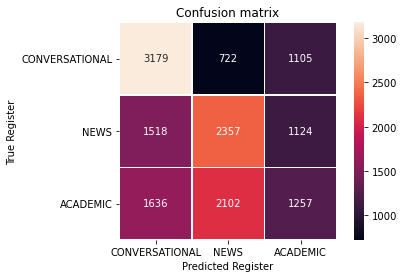

0.5271293121407369 ['average_dependency_distance']


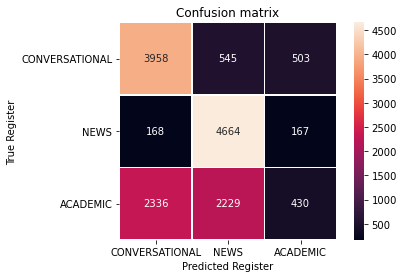

In [19]:
# Get the model with the best/worst f1 scores
best_models = sorted(models, key=lambda m: m.f1)[:-5:-1]
worst_models = sorted(models, key=lambda m: m.precision)[:5]


# Print their confusion matrices and f1 scores
for model in best_models + worst_models:
  print(model.f1, model.features)
  model.plot_confusion_matrix(model.confusion_matrix)

### Evaluate a model trained on all features

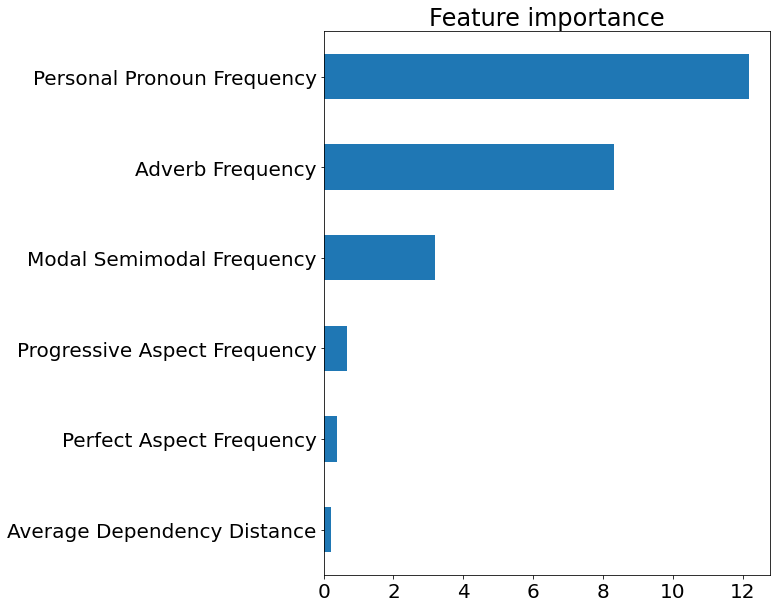

In [20]:
def print_coef(model):
  coeffs = [0] * 6
  for i in range(len(model.coef_)):
    for j in range(len(model.coef_[i])):
      coeffs[j] += abs(model.coef_[i][j])
  
  for i in range(len(coeffs)):
    coeffs[i] /= 3

    
  coef = pd.Series(coeffs, index = map(lambda ss: ' '.join(ss).title(), map(lambda s: s.split('_'), feature_names)))
  imp_coef = coef.sort_values()
  import matplotlib
  matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
  matplotlib.rcParams['font.size'] = 20
  imp_coef.plot(kind = "barh")
  plt.title("Feature importance")

all_feature_model = [m for m in models if len(m.features) == len(feature_names)][0]
print_coef(all_feature_model)


### Evaluate models trained on single features

In [21]:
single_feature_models = [m for m in models if len(m.features) == 1]
for model in sorted(single_feature_models, key=lambda m: m.f1):
  print(model.features, model.f1)

['modal_semimodal_frequency'] 0.3127894932312593
['progressive_aspect_frequency'] 0.37267238914995876
['perfect_aspect_frequency'] 0.37393954026905596
['adverb_frequency'] 0.4717910004079641
['average_dependency_distance'] 0.5271293121407369
['personal_pronoun_frequency'] 0.6599050397429559
